In [1]:
# import xarray as xr
import pandas as pd
import math
import numpy as np
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

In [2]:
def math_wind(speed, direc):
    md = 270-direc
    md = np.array(np.where(md>0,md,md+360))

    u = np.array([speed[i] * math.cos(math.radians(md[i])) for i in range(len(md))])
    v = np.array([speed[i] * math.sin(math.radians(md[i])) for i in range(len(md))])

    return u, v #remember that u is EW and v is NS

def calc_stats(x, y):
    stats = {}
    MSE = np.mean((y - x)**2)
    stats['RMSE'] = np.sqrt(MSE)
    stats['bias'] = np.mean(y) - np.mean(x)
    stats['WSS'] = 1 - MSE / np.mean((abs(y - np.mean(x)) + abs(x - np.mean(x)))**2)
    
    return stats

def plot_panel(ax, x, y, lims, units):
    stats = calc_stats(x, y)

    statstext = f"RMSE = {stats['RMSE']:.3f} {units}\nbias = {stats['bias']:.3f} {units}\nWSS = {stats['WSS']:.3f}"
    
    props = dict(boxstyle='round', facecolor='w', alpha=0.9)
    c = ax.text(0.5, 0.04, statstext, bbox=props, transform=ax.transAxes, fontsize=9)
    ax.set_xlim(lims)
    ax.set_ylim(lims)
    
    return c

# first working in barkley canyon
currents: scalar_1196714 <br>
ctd: scalar_1196717 <br>
oxygen: scalar_1196720

In [3]:
df = pd.read_pickle('/data1/bbeutel/LO_output/extract_cast/onc/scalar_1196714.p')

In [4]:
df['u'], df['v'] = math_wind(df['current_speed_calculated (m s-1)'], df['current_direction_calculated (degree)'])
# now that's a bit to much to plot, do average by day
df = df.set_index('time (UTC)')
df = df.resample('D',axis=0).mean()
df.head()

,current_speed_calculated (m s-1),current_direction_calculated (degree),Temperature (K),latitude (degrees_north),longitude (degrees_east),depth (m),model_u,model_v,model_t,u,v
time (UTC),,,,,,,,,,,
2017-06-15 00:00:00+00:00,0.077357,178.775348,278.927759,48.3332,-125.875583,415.0,0.021130,0.022980,278.683088,-0.011174,-0.006938
2017-06-16 00:00:00+00:00,0.063693,193.807105,278.943194,48.3332,-125.875583,415.0,0.012977,0.020914,278.706591,0.002317,0.000096
2017-06-17 00:00:00+00:00,0.063835,183.289153,278.931667,48.3332,-125.875583,415.0,0.006640,0.015570,278.766170,0.005124,0.001060
2017-06-18 00:00:00+00:00,0.080721,202.824317,278.985417,48.3332,-125.875583,415.0,-0.001184,0.001145,278.799099,0.009473,-0.006357
2017-06-19 00:00:00+00:00,0.058084,182.652493,278.901667,48.3332,-125.875583,415.0,0.013639,0.026353,278.768426,0.000718,0.000613


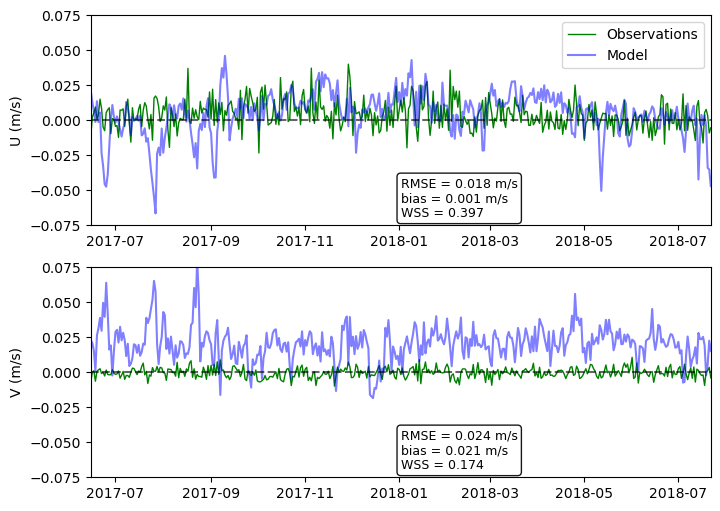

In [5]:
fig,ax = plt.subplots(2,1,figsize=(8,6))

ax[0].plot(df.index, df['u'],'g',lw=1,label='Observations')
ax[0].plot(df.index, df['model_u'],'b',label='Model',alpha=0.5)
ax[0].set_ylabel('U (m/s)')
ax[0].legend()
# plot the stats pannel
plot_panel(ax[0], df['u'], df['model_u'], (-0.1,0.1), 'm/s')

ax[1].plot(df.index, df['v'],'g',lw=1,label='Observations')
ax[1].plot(df.index, df['model_v'],'b',label='Model',alpha=0.5)
ax[1].set_ylabel('V (m/s)')
# plot the stats pannel
plot_panel(ax[1], df['v'], df['model_v'], (-0.1,0.1), 'm/s')

for i in range(len(ax)):
    ax[i].set_ylim([-0.075,0.075])
    ax[i].set_xlim([np.min(df.index),np.max(df.index)])
    ax[i].plot([np.min(df.index),np.max(df.index)],[0,0],'k--',alpha=0.6)


(17332.0, 17734.0)

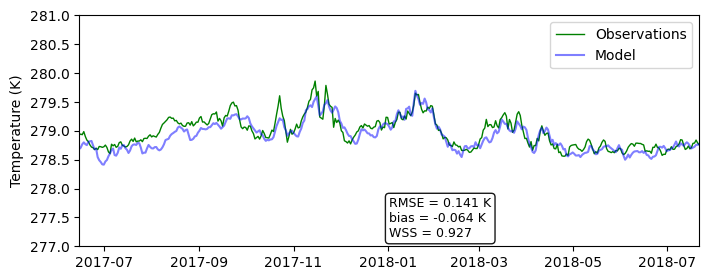

In [6]:
# what about temperature?
fig,ax = plt.subplots(1,1,figsize=(8,3))

ax.plot(df.index, df['Temperature (K)'],'g',lw=1,label='Observations')
ax.plot(df.index, df['model_t'],'b',label='Model',alpha=0.5)
ax.set_ylabel('Temperature (K)')
ax.legend()
# plot the stats pannel
plot_panel(ax, df['Temperature (K)'], df['model_t'], (277,281), 'K')
ax.set_xlim([np.min(df.index),np.max(df.index)])

(17332.0, 17734.0)

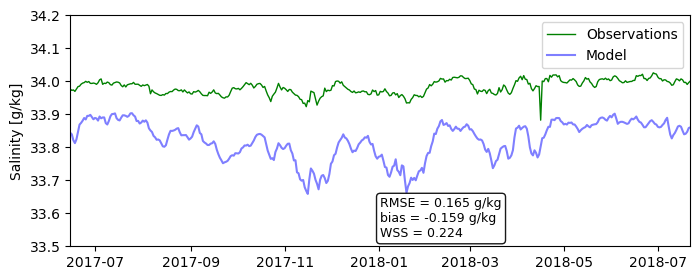

In [7]:
# salinity?
df = pd.read_pickle('/data1/bbeutel/LO_output/extract_cast/onc/scalar_1196717_ctd.p').set_index('datetime').resample('D',axis=0).mean()

fig,ax = plt.subplots(1,1,figsize=(8,3))
ax.plot(df.index, df['salinity (1e-3)'],'g',lw=1,label='Observations')
ax.plot(df.index, df['model_s'],'b',label='Model',alpha=0.5)
ax.set_ylabel('Salinity [g/kg]')
ax.legend()
# plot the stats pannel
plot_panel(ax, df['salinity (1e-3)'], df['model_s'], (33.5,34.2), 'g/kg')
ax.set_xlim([np.min(df.index),np.max(df.index)])

(17332.0, 17734.0)

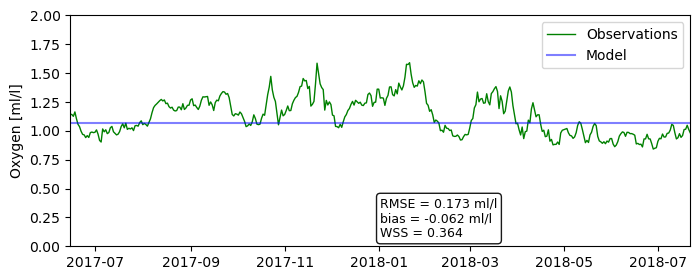

In [10]:
# oxygen?

do = pd.read_pickle('/data1/bbeutel/LO_output/extract_cast/onc/scalar_1196720_oxy.p').set_index('datetime').resample('D',axis=0).mean()

# must convert to correct units here where we have temperature
# from Tall:
# o2=0.7.*o21; % mg/l --> ml/l
# o2=o2.*44.661; % ml/l --> µmol/l = mmol/m3
do['model_o [ml/l]'] = do['model_o  [mmol/m3'] / 44.661

fig,ax = plt.subplots(1,1,figsize=(8,3))
ax.plot(do.index, do['oxygen_corrected (ml/l)'],'g',lw=1,label='Observations')
ax.plot(do.index, do['model_o [ml/l]'],'b',label='Model',alpha=0.5)
ax.set_ylabel('Oxygen [ml/l]')
ax.legend()
# plot the stats pannel
plot_panel(ax, do['oxygen_corrected (ml/l)'], do['model_o [ml/l]'], (0,2), 'ml/l')
ax.set_xlim([np.min(do.index),np.max(do.index)])

In [11]:
do

,oxygen_corrected (ml/l),longitude (degrees_east),latitude (degrees_north),depth (m),model_o [mmol/m3],model_o [mmol/m3,model_o [ml/l]
datetime,,,,,,,
2017-06-15 00:00:00+00:00,1.144067,-125.875583,48.3332,415.0,NaN,47.572647,1.065194
2017-06-16 00:00:00+00:00,1.140653,-125.875583,48.3332,415.0,NaN,47.572647,1.065194
2017-06-17 00:00:00+00:00,1.125028,-125.875583,48.3332,415.0,NaN,47.572647,1.065194
2017-06-18 00:00:00+00:00,1.163292,-125.875583,48.3332,415.0,NaN,47.572647,1.065194
2017-06-19 00:00:00+00:00,1.104361,-125.875583,48.3332,415.0,NaN,47.572647,1.065194
...,...,...,...,...,...,...,...
2018-07-18 00:00:00+00:00,1.010889,-125.875583,48.3332,415.0,NaN,47.572647,1.065194
2018-07-19 00:00:00+00:00,1.013000,-125.875583,48.3332,415.0,NaN,47.572647,1.065194
2018-07-20 00:00:00+00:00,1.047653,-125.875583,48.3332,415.0,NaN,47.572647,1.065194


# Endeavour North
curent: scalar_1200222
ctd: scalar_1200219 


In [10]:
df = pd.read_pickle('/data1/bbeutel/LO_output/extract_cast/onc/scalar_1200222.p')
df['u'], df['v'] = math_wind(df['current_speed_calculated (m s-1)'], df['current_direction_calculated (degree)'])
# now that's a bit to much to plot, do average by day
df = df.set_index('datetime')
df = df.resample('D',axis=0).mean()
df.head()

,current_speed_calculated (m s-1),current_direction_calculated (degree),Temperature (K),latitude (degrees_north),longitude (degrees_east),depth (m),model_u,model_v,model_t,u,v
datetime,,,,,,,,,,,
2019-05-14 00:00:00+00:00,0.075686,141.513850,275.285156,47.973617,-129.08254,2157.0,0.010700,0.006636,274.975201,-0.046769,0.059484
2019-05-15 00:00:00+00:00,0.049639,131.261136,275.313354,47.973617,-129.08254,2157.0,0.043158,0.010695,274.980959,-0.036717,0.032886
2019-05-16 00:00:00+00:00,0.049398,133.042579,275.306076,47.973617,-129.08254,2157.0,0.037091,0.021455,274.975600,-0.036139,0.033272
2019-05-17 00:00:00+00:00,0.046682,129.568563,275.305639,47.973617,-129.08254,2157.0,0.028000,0.020924,274.977069,-0.033797,0.030885
2019-05-18 00:00:00+00:00,0.045280,136.434566,275.291500,47.973617,-129.08254,2157.0,0.030342,0.022332,274.980383,-0.030330,0.031405


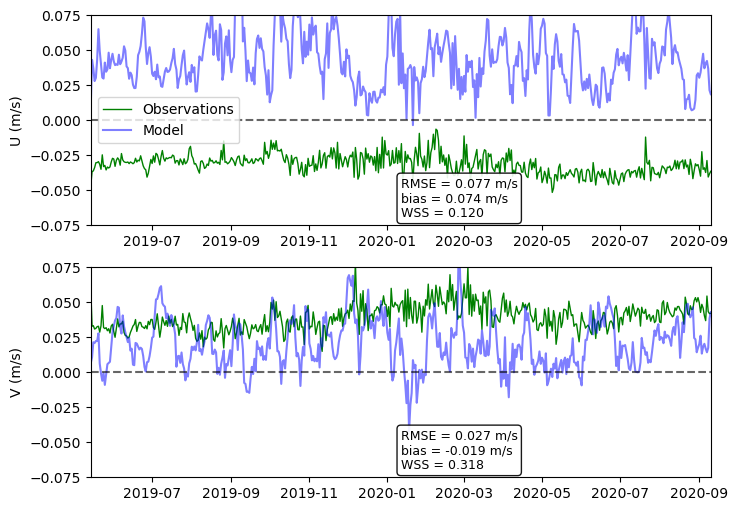

In [11]:
fig,ax = plt.subplots(2,1,figsize=(8,6))

ax[0].plot(df.index, df['u'],'g',lw=1,label='Observations')
ax[0].plot(df.index, df['model_u'],'b',label='Model',alpha=0.5)
ax[0].set_ylabel('U (m/s)')
ax[0].legend()
# plot the stats pannel
plot_panel(ax[0], df['u'], df['model_u'], (-0.1,0.1), 'm/s')

ax[1].plot(df.index, df['v'],'g',lw=1,label='Observations')
ax[1].plot(df.index, df['model_v'],'b',label='Model',alpha=0.5)
ax[1].set_ylabel('V (m/s)')
# plot the stats pannel
plot_panel(ax[1], df['v'], df['model_v'], (-0.1,0.1), 'm/s')

for i in range(len(ax)):
    ax[i].set_ylim([-0.075,0.075])
    ax[i].set_xlim([np.min(df.index),np.max(df.index)])
    ax[i].plot([np.min(df.index),np.max(df.index)],[0,0],'k--',alpha=0.6)

(18030.0, 18515.0)

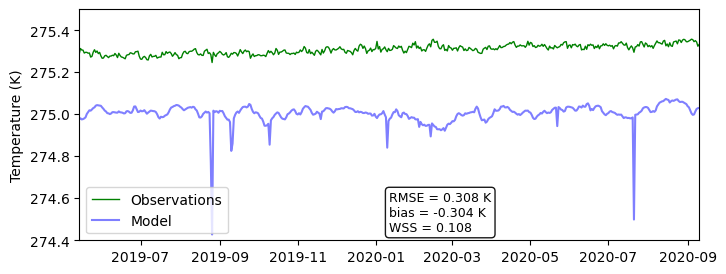

In [18]:
# what about temperature?
fig,ax = plt.subplots(1,1,figsize=(8,3))

ax.plot(df.index, df['Temperature (K)'],'g',lw=1,label='Observations')
ax.plot(df.index, df['model_t'],'b',label='Model',alpha=0.5)
ax.set_ylabel('Temperature (K)')
ax.legend(loc="lower left")
# plot the stats pannel
plot_panel(ax, df['Temperature (K)'], df['model_t'], (274.4,275.5), 'K')
ax.set_xlim([np.min(df.index),np.max(df.index)])

(18030.0, 18515.0)

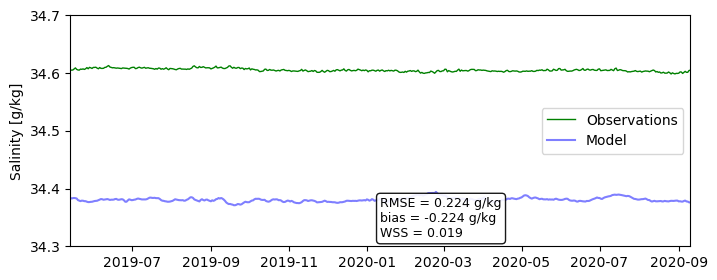

In [22]:
# salinity?
df = pd.read_pickle('/data1/bbeutel/LO_output/extract_cast/onc/scalar_1200219_ctd.p').set_index('datetime').resample('D',axis=0).mean()

fig,ax = plt.subplots(1,1,figsize=(8,3))
ax.plot(df.index, df['salinity (1e-3)'],'g',lw=1,label='Observations')
ax.plot(df.index, df['model_s'],'b',label='Model',alpha=0.5)
ax.set_ylabel('Salinity [g/kg]')
ax.legend()
# plot the stats pannel
plot_panel(ax, df['salinity (1e-3)'], df['model_s'], (34.3,34.7), 'g/kg')
ax.set_xlim([np.min(df.index),np.max(df.index)])